# **Group Project Machine Learning**

**Authors:**
- António Fiúza, 46865
- Lucas Almeida, 59662
- Maria Catarina Pereira, 58685
- Mariana Godinho, 47208
- Martim Ernesto, 46953


# **Introduction**

In the field of medical diagnostics, the X-ray stands as a fundamental tool, offering invaluable insights into the pulmonary conditions affecting patients. This project leverages a dataset of chest X-ray images to develop an Artificial Intelligence based system, capable of distinguishing between bacterial and viral pneumonia, as well as normal pulmonary conditions.

The dataset consists on a total of 5,863 high-quality JPEG images. These images fall into two distinct categories: Pneumonia and Normal, representing affected and healthy states, respectively. Each image in the dataset is a representation of an anterior-posterior chest X-ray from pediatric patients aged one to five years, which were originally obtained as part of routine clinical care.

This AI project seeks to automate the detection of pneumonia from chest X-rays. The insights derived from this process can significantly streamline the diagnostic process, therefore reducing the workload on medical professionals, and ultimately, improving patient outcomes.

## **Imports & Setup**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import re
import shutil
import string
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import losses
import zipfile
import json
import numpy as np
import hashlib
np.random.seed(42)
tf.random.set_seed(42)

In [31]:
def plot_history(history, label):
    """
    Plot the training and validation accuracy, precision, and recall
    """
    # Accuracy
    axs[0].plot(history.history['accuracy'], label='Train Accuracy_{}'.format(label))
    axs[0].plot(history.history['val_accuracy'], label='Val Accuracy_{}'.format(label), linestyle='dashed')
    axs[0].set_title('Model Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Accuracy')
    axs[0].legend(loc='lower right')

    # Loss
    axs[1].plot(history.history['loss'], label='Train Loss_{}'.format(label))
    axs[1].plot(history.history['val_loss'], label='Val Loss_{}'.format(label), linestyle='dashed')
    axs[1].set_title('Model Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Loss')
    axs[1].legend(loc='lower right')

    plt.tight_layout()

In [10]:
# Unzip the source data
dataset_dir =  "/content/drive/MyDrive/assignmentML/"

zip_file = 'chest_xray.zip'

zip_path = os.path.join(dataset_dir, zip_file)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(dataset_dir)

print(os.listdir(dataset_dir))

['archive.zip', 'CURRENT_projetoML.ipynb', 'codigo_inicio.ipynb', '.kaggle', 'projetoML (2)_com_inicio.ipynb', 'projetoML_EDA_DNN.ipynb 2', 'extra_images.zip', 'projetoML_final.ipynb', 'projetoML_EDA_DNN (2).ipynb', 'projetoML.ipynb', 'Limpo.ipynb', 'out_of_sample_data.zip', 'Limpo lucas.ipynb', 'chest_xray.zip', 'chest_xray']


In [11]:
# DIRECTORIES
dataset_dir = "/content/drive/MyDrive/assignmentML/chest_xray/images"
normal_dir = os.path.join(dataset_dir, 'NORMAL')
pneumonia_dir = os.path.join (dataset_dir, 'PNEUMONIA')

In [12]:
for file_name in os.listdir(normal_dir):
    if file_name == ".DS_Store":
        file_path = os.path.join(normal_dir, file_name)
        os.remove(file_path)

for file_name in os.listdir(pneumonia_dir):
    if file_name == ".DS_Store":
        file_path = os.path.join(pneumonia_dir, file_name)
        os.remove(file_path)

### Plotting 4 Images from each class

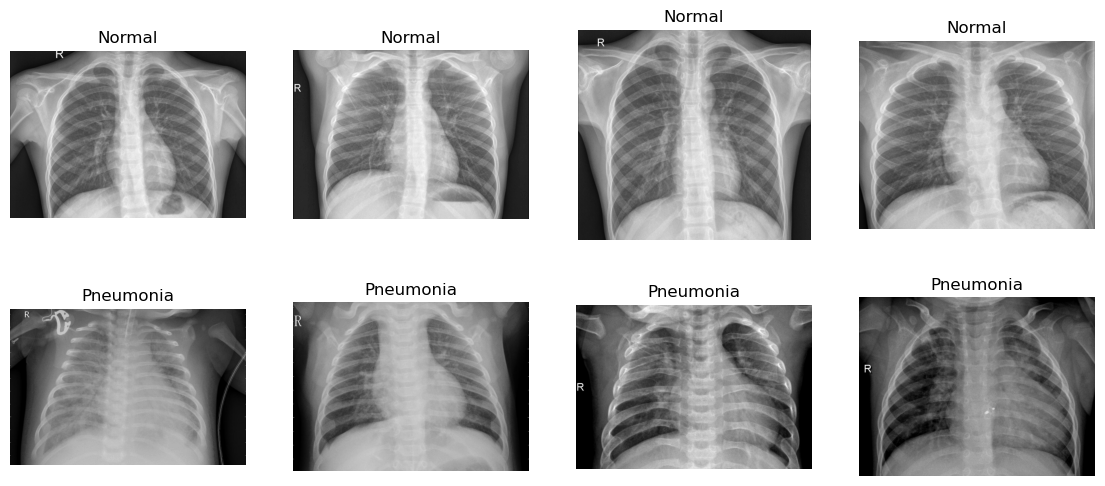

In [ ]:
normal_images = [os.path.join(normal_dir, img) for img in os.listdir(normal_dir)[:4]]

pneumonia_images = [os.path.join(pneumonia_dir, img) for img in os.listdir(pneumonia_dir)[:4]]

plt.figure(figsize=(14, 6))
for i, image_path in enumerate(normal_images):
    plt.subplot(2, 4, i+1)
    image = mpimg.imread(image_path)
    plt.imshow(image, cmap='gray')
    plt.title('Normal')
    plt.axis('off')

for i, image_path in enumerate(pneumonia_images):
    plt.subplot(2, 4, i+5)
    image = mpimg.imread(image_path)
    plt.imshow(image, cmap='gray')
    plt.title('Pneumonia')
    plt.axis('off')

plt.show()

## **Exploratory Data Analysis**

### Checking Image Balance

In [ ]:
normal_dir = os.path.join(dataset_dir, 'NORMAL')
pneumonia_dir = os.path.join(dataset_dir, 'PNEUMONIA')

num_normal_images = len(os.listdir(normal_dir))
num_pneumonia_images = len(os.listdir(pneumonia_dir))

print(f"Number of NORMAL images: {num_normal_images}")
print(f"Number of PNEUMONIA images: {num_pneumonia_images}")

total_images = num_normal_images + num_pneumonia_images
normal_ratio = num_normal_images / total_images
pneumonia_ratio = num_pneumonia_images / total_images

print(f"Ratio of NORMAL images: {normal_ratio}")
print(f"Ratio of PNEUMONIA images: {pneumonia_ratio}")

Number of NORMAL images: 1575
Number of PNEUMONIA images: 4265
Ratio of NORMAL images: 0.2696917808219178
Ratio of PNEUMONIA images: 0.7303082191780822


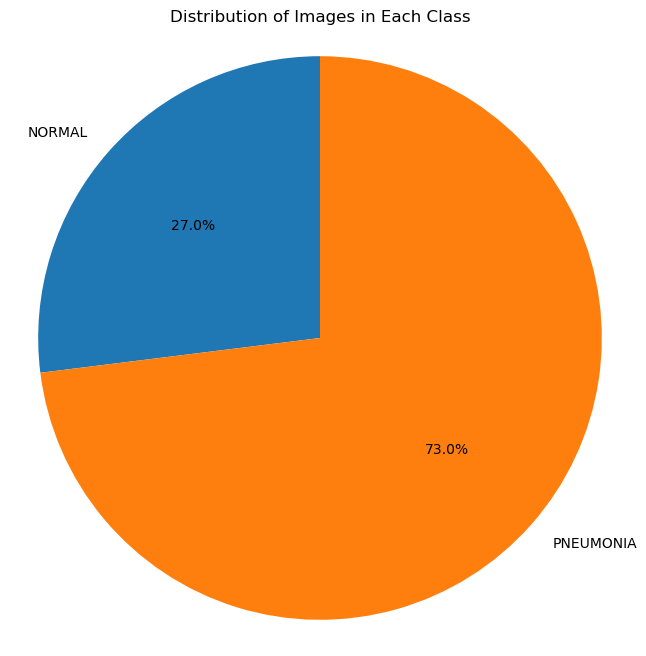

In [ ]:
labels = ['NORMAL', 'PNEUMONIA']
sizes = [num_normal_images, num_pneumonia_images]

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Images in Each Class')
plt.axis('equal')
plt.show()


The dataset appears to be highly imbalanced, with significantly more samples in the pneumonia class compared to the normal class. Specifically:

The normal class has 1575 samples.
The pneumonia class has 4265 samples.
The imbalance ratio (normal:pneumonia) is approximately 0.27.

This means that approximately 27% of the dataset belongs to the normal class, while the remaining 73% belongs to the pneumonia class.

Imbalanced datasets can present challenges during model training, as the model may become biased towards the majority class.

**Considerations regarding these results:**

We believe that might be important to Rebalance the dataset by using techniques like data augmentation, oversampling the normal class, or undersampling the pneumonia class in the training set to prevent model bias.

Also, increasing the validation data might be necessary to ensure that our models are evaluated more robustly.

### Addressing Class Imbalance

- To address the imbalance present in our dataset, we are  augmenting the 'normal' class by adding additional non-pneumonia X-ray images. This augmentation strategy aims to solve the disproportionate representation of classes within the dataset, thus obtaining a more balanced and robust model training process.
- We seek to enhance the model's ability to differentiate between pneumonia and non-pneumonia cases accurately, ultimately improving the model's performance and generalization capability.


In [14]:
#Unzip extra images file
dataset_dir = "/content/drive/MyDrive/assignmentML"

zip_file = 'extra_images.zip'

zip_path = os.path.join(dataset_dir, zip_file)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(dataset_dir)

In [15]:
#Transfering images from extra_images to chest_xray:
extra_images_dir = "/content/drive/MyDrive/assignmentML/TB_Chest_Radiography_Database/Normal"

for file in os.listdir(extra_images_dir):
    src_path = os.path.join(extra_images_dir, file)
    dest_path = os.path.join(normal_dir, file)
    shutil.copy(src_path, dest_path)

print("Images added.")

Images added.


In [ ]:
num_normal_images = len(os.listdir(normal_dir))
num_pneumonia_images = len(os.listdir(pneumonia_dir))

print(f"Number of NORMAL images: {num_normal_images}")
print(f"Number of PNEUMONIA images: {num_pneumonia_images}")

total_images = num_normal_images + num_pneumonia_images
normal_ratio = num_normal_images / total_images
pneumonia_ratio = num_pneumonia_images / total_images

print(f"Ratio of NORMAL images: {normal_ratio}")
print(f"Ratio of PNEUMONIA images: {pneumonia_ratio}")

Number of NORMAL images: 5075
Number of PNEUMONIA images: 4265
Ratio of NORMAL images: 0.5433618843683083
Ratio of PNEUMONIA images: 0.45663811563169165


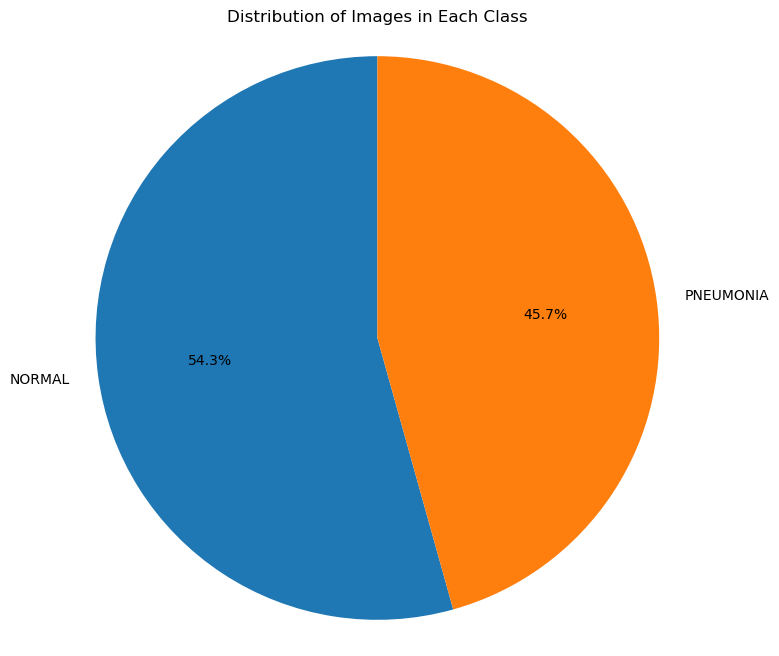

In [ ]:
sizes = [num_normal_images, num_pneumonia_images]

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Images in Each Class')
plt.axis('equal')
plt.show()

### Converting all images to JPEG

In [16]:
from PIL import Image
for file_name in os.listdir(normal_dir):
    # Check if the file is not a JPEG file
    if not file_name.endswith(".jpeg"):
        # Construct the full path to the image file
        file_path = os.path.join(normal_dir, file_name)

        # Open the image using PIL
        image = Image.open(file_path)

        # Construct the new file name with the JPEG extension
        new_file_name = os.path.splitext(file_name)[0] + ".jpeg"

        # Save the image in JPEG format, overwriting the original file
        image.save(os.path.join(normal_dir, new_file_name), "JPEG")

        # Delete the original file
        os.remove(file_path)

print("Conversion completed.")

Conversion completed.


### Convert to JPEG

In [17]:
from PIL import Image
for file_name in os.listdir(normal_dir):
    # Check if the file is not a JPEG file
    if not file_name.endswith(".jpeg"):
        # Construct the full path to the image file
        file_path = os.path.join(normal_dir, file_name)

        # Open the image using PIL
        image = Image.open(file_path)

        # Construct the new file name with the JPEG extension
        new_file_name = os.path.splitext(file_name)[0] + ".jpeg"

        # Save the image in JPEG format, overwriting the original file
        image.save(os.path.join(normal_dir, new_file_name), "JPEG")

        # Delete the original file
        os.remove(file_path)

print("Conversion completed.")

Conversion completed.


### Check if images have the same format

In [18]:
# Define the directories to check
directories_to_check = [normal_dir,pneumonia_dir]

# Iterate through each directory
for directory in directories_to_check:
    # Initialize counters for jpeg files and total files
    jpeg_count = 0
    total_count = 0

    # Iterate through each file in the directory
    for file_name in os.listdir(directory):
        # Check if the file name ends with ".jpeg"
        if file_name.lower().endswith(".jpeg"):
            # Increment the jpeg counter if it does
            jpeg_count += 1
        # Increment the total counter for each file
        total_count += 1

    # Print the counts for the current directory
    print("Number of .jpeg files in", directory, ":", jpeg_count)
    print("Number of total images in", directory, ":", total_count)
    print()


Number of .jpeg files in /content/drive/MyDrive/assignmentML/chest_xray/images/NORMAL : 5075
Number of total images in /content/drive/MyDrive/assignmentML/chest_xray/images/NORMAL : 5075

Number of .jpeg files in /content/drive/MyDrive/assignmentML/chest_xray/images/PNEUMONIA : 4265
Number of total images in /content/drive/MyDrive/assignmentML/chest_xray/images/PNEUMONIA : 4265



### Check if images are grayscale or RGB

In [ ]:
# Define the directories to check
directories_to_check = [normal_dir, pneumonia_dir]

# Iterate through each directory
for directory in directories_to_check:
    # Initialize counters for grayscale and RGB images
    grayscale_count = 0
    rgb_count = 0

    # Iterate through each file in the directory
    for file_name in os.listdir(directory):
        # Construct the full path to the image
        file_path = os.path.join(directory, file_name)

        # Open the image
        image = Image.open(file_path)

        # Check the mode of the image
        if image.mode == "L":
            # Grayscale mode
            grayscale_count += 1
        elif image.mode == "RGB":
            # RGB mode
            rgb_count += 1

    # Print the counts for the current directory
    print("Number of grayscale images in", directory, ":", grayscale_count)
    print("Number of RGB images in", directory, ":", rgb_count)
    print()


Number of grayscale images in /home/martim_esteves1/Machine Learning/group_work2/chest_xray/images/NORMAL : 5071
Number of RGB images in /home/martim_esteves1/Machine Learning/group_work2/chest_xray/images/NORMAL : 0

Number of grayscale images in /home/martim_esteves1/Machine Learning/group_work2/chest_xray/images/PNEUMONIA : 4237
Number of RGB images in /home/martim_esteves1/Machine Learning/group_work2/chest_xray/images/PNEUMONIA : 0



### Check if there are any duplicate images

In [22]:
# Function to calculate the hash of a file
def file_hash(file_path):
    # Initialize the hash object
    hasher = hashlib.md5()
    # Read the file in binary mode
    with open(file_path, 'rb') as f:
        # Update the hasher with the file content
        hasher.update(f.read())
    # Return the hexadecimal representation of the hash
    return hasher.hexdigest()

# Define the directories to check
directories_to_check = [normal_dir, pneumonia_dir]

# Iterate through each directory
for directory in directories_to_check:
    # Initialize a counter for total images
    total_images = 0

    # Print the directory path
    print("Directory:", directory)

    # Iterate through each file in the directory
    for file_name in os.listdir(directory):
        total_images += 1

    # Print the number of images in the directory
    print("Total images:", total_images)

    # Initialize a dictionary to store hashes
    hashes = {}

    # Initialize a counter for duplicate images
    duplicate_count = 0

    # Iterate through each file in the directory again
    for file_name in os.listdir(directory):
        # Construct the full path to the image
        file_path = os.path.join(directory, file_name)
        # Calculate the hash of the file
        file_hash_value = file_hash(file_path)
        # Check if the hash is already in the dictionary
        if file_hash_value in hashes:
            print("Duplicate found:", file_path)
            duplicate_count += 1
        else:
            # Store the hash in the dictionary
            hashes[file_hash_value] = file_path

    # Print the count of duplicate images for the directory
    print("Total duplicate images:", duplicate_count)


Directory: /content/drive/MyDrive/assignmentML/chest_xray/images/NORMAL
Total images: 5075
Duplicate found: /content/drive/MyDrive/assignmentML/chest_xray/images/NORMAL/NORMAL2-IM-0096-0001.jpeg
Duplicate found: /content/drive/MyDrive/assignmentML/chest_xray/images/NORMAL/NORMAL2-IM-0173-0001-0002.jpeg
Duplicate found: /content/drive/MyDrive/assignmentML/chest_xray/images/NORMAL/NORMAL2-IM-0246-0001-0002.jpeg
Duplicate found: /content/drive/MyDrive/assignmentML/chest_xray/images/NORMAL/NORMAL2-IM-0587-0001-0002.jpeg
Total duplicate images: 4
Directory: /content/drive/MyDrive/assignmentML/chest_xray/images/PNEUMONIA
Total images: 4265
Duplicate found: /content/drive/MyDrive/assignmentML/chest_xray/images/PNEUMONIA/person1159_virus_1945.jpeg
Duplicate found: /content/drive/MyDrive/assignmentML/chest_xray/images/PNEUMONIA/person124_virus_247.jpeg
Duplicate found: /content/drive/MyDrive/assignmentML/chest_xray/images/PNEUMONIA/person1261_virus_2148.jpeg
Duplicate found: /content/drive/MyDr

In [ ]:
# Function to calculate the hash of a file
def file_hash(file_path):
    # Initialize the hash object
    hasher = hashlib.md5()
    # Read the file in binary mode
    with open(file_path, 'rb') as f:
        # Update the hasher with the file content
        hasher.update(f.read())
    # Return the hexadecimal representation of the hash
    return hasher.hexdigest()

# Define the directories to check
directories_to_check = [normal_dir, pneumonia_dir]

# Iterate through each directory
for directory in directories_to_check:
    # Initialize a counter for total images
    total_images = 0

    # Print the directory path
    print("Directory:", directory)

    # Iterate through each file in the directory
    for file_name in os.listdir(directory):
        total_images += 1

    # Print the number of images in the directory
    print("Total images:", total_images)

    # Initialize a dictionary to store hashes
    hashes = {}

    # Initialize a counter for duplicate images
    duplicate_count = 0

    # Iterate through each file in the directory again
    for file_name in os.listdir(directory):
        # Construct the full path to the image
        file_path = os.path.join(directory, file_name)
        # Calculate the hash of the file
        file_hash_value = file_hash(file_path)
        # Check if the hash is already in the dictionary
        if file_hash_value in hashes:
            print("Duplicate found:", file_path)
            duplicate_count += 1
            # Remove the duplicate file
            os.remove(file_path)
        else:
            # Store the hash in the dictionary
            hashes[file_hash_value] = file_path

    # Print the count of duplicate images for the directory
    print("Total duplicate images:", duplicate_count)
    print()


Directory: /home/martim_esteves1/Machine Learning/group_work2/chest_xray/images/NORMAL
Total images: 5071
Total duplicate images: 0

Directory: /home/martim_esteves1/Machine Learning/group_work2/chest_xray/images/PNEUMONIA
Total images: 4237
Total duplicate images: 0



## **MODELS**

**Evaluation Metrics:**
We will evaluate the model using the following metrics:

- Accuracy: Overall classification accuracy.
- Precision: Proportion of true positive predictions out of all positive predictions.
- Recall: Proportion of true positive predictions out of all actual positives.
- F1-score: Harmonic mean of precision and recall.

### Initial Setup:
 - Importing the transformed data (after EDA)
 - Splitting the data into training and validation sets (set image size to 256x256 and batch size to 8)
 - Normalize the pixel scale and optimize the data pipeline for performance
 - Define Utility Functions to save and load model weights and training histories


In [23]:
dataset_dir = "/content/drive/MyDrive/assignmentML/chest_xray/images"
batch_size = 32
img_height = 256
img_width = 256
validation_split = 0.2

train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=validation_split,
    subset="training",
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=validation_split,
    subset="validation",
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

Found 9340 files belonging to 2 classes.
Using 7472 files for training.
Found 9340 files belonging to 2 classes.
Using 1868 files for validation.


In [24]:
total_train_samples = len(train_ds)
total_val_samples = len(val_ds)

# Calculate the number of samples for the smaller datasets (1/5 of the original)
smaller_train_samples = total_train_samples // 5
smaller_val_samples = total_val_samples // 5

# Create smaller datasets by slicing
train_ds = train_ds.take(smaller_train_samples)
val_ds = val_ds.take(smaller_val_samples)

In [25]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Base line model - Deep Neural Network

**Model Architecture:**
- Input Layer: Flatten layer to flatten the input images.
- Hidden Layers: Two dense layers with 256 and 128 units respectively, using ReLU activation.
- Output Layer: Dense layer with 1 unit and sigmoid activation for binary classification.

In [ ]:
batch_size = 32
img_height = 256
img_width = 256

In [91]:
# Define the model
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(img_height, img_width, 3)),  # Flatten the input image
    tf.keras.layers.Dense(64, activation='relu'),  # Dense layer with 128 units and ReLU activation
    tf.keras.layers.Dense(1, activation='softmax')  # Output layer with softmax activation
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

# Train the model
history = model.fit(train_ds, epochs=10, validation_data=val_ds)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_10 (Flatten)        (None, 196608)            0         
                                                                 
 dense_28 (Dense)            (None, 64)                12582976  
                                                                 
 dense_29 (Dense)            (None, 1)                 65        
                                                                 
Total params: 12583041 (48.00 MB)
Trainable params: 12583041 (48.00 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
46/46 [==============================] - 7s 131ms/step - loss: nan - accuracy: 0.5408 - val_loss: nan - val_accuracy: 0.5909
Epoch 2/10
46/46 [==============================] - 1s 16ms/step - loss: nan - accuracy: 0.5462 - val_loss: nan - val_accuracy: 0.5909
Epoch

In [92]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Make predictions on the validation dataset
y_pred = model.predict(val_ds)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get the true labels of the validation dataset
y_true = []
for images, labels in val_ds:
    y_true.extend(labels.numpy())

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred_classes)

# Calculate precision
precision = precision_score(y_true, y_pred_classes)

# Calculate recall
recall = recall_score(y_true, y_pred_classes)

# Calculate F1 score
f1 = f1_score(y_true, y_pred_classes)

print("Confusion Matrix:")
print(conf_matrix)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


11/11 [==============================] - 0s 10ms/step
Confusion Matrix:
[[208   0]
 [144   0]]
Accuracy: 0.5909090909090909
Precision: 0.0
Recall: 0.0
F1 Score: 0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



**Confusion Matrix**
The confusion matrix is given as:

[[208   0]  
 [144   0]]

- True Positives (TP): 0 – The model correctly predicted the positive class 0 times.
- True Negatives (TN): 208 – The model correctly predicted the negative class 208 times.
- False Positives (FP): 0 – The model incorrectly predicted the positive class 0 times (none of the negative instances were wrongly classified as positive).
- False Negatives (FN): 144 – The model incorrectly predicted the negative class 144 times (positive instances were wrongly classified as negative).


**Accuracy**
Accuracy is the proportion of total correct predictions (both true positives and true negatives) out of all predictions made. The model has an accuracy of 59.09%, which means it correctly predicts the class of 59.09% of the instances. However, accuracy can be misleading in cases of imbalanced classes, as is likely the case here.

**Precision**
Precision is the proportion of true positive predictions out of all positive predictions made. The precision is 0. This indicates that when the model predicts the positive class, it is never correct. This is expected since the model did not predict any positives.


**Recall**
Recall is the proportion of true positive predictions out of all actual positives. The recall is 0. This means the model failed to identify any of the actual positive instances.

**F1 Score**
The F1 score is the harmonic mean of precision and recall. The F1 score is 0, reflecting the complete failure of the model to make any correct positive predictions.

#### CONCLUSION:
The performance metrics indicate that the model is severely biased towards predicting the negative class. It correctly identifies all negative instances but fails to recognize any positive instances. This results in a perfect precision and recall of zero for the positive class. The high number of false negatives (144) is a significant concern, as the model is missing all positive cases.

### Convolutional Neural Network - Own Training

For this part of the model training, we prioritized training lots of different models to find the architecture that best fits our problem. We trained four different convolution models, and applied all possible overfitting techniques (e.g. early stopping, dropout, batch normalization, etc.), prior to the model test, instaed of applying techniques one at a time in an ablation study manner. This allows us to test a bigger range of models, as it would be impractical to do a study for each model, for the quantity of models we tested.

### **CNN 1**

**Model Architecture**:

- Input Layer Input layer specifying image dimensions.
- Convolutional Layers: 4 blocks with Conv2D or SeparableConv2D layers, each followed by Batch Normalization and MaxPooling2D.
- Fully Connected Layers: Two dense layers with ReLU activation.
- Output Layer: Dense layer with sigmoid activation.

Resembles: VGG-like architecture with deeper layers and separable convolutions for efficiency.

Overfitting Solving Techniques:
- Batch Normalization: Stabilizes and accelerates training.
- Dropout: Reduces overfitting by randomly dropping units during training.

In [28]:
from functools import partial
from tensorflow import keras

# Define a default convolutional layer with specified parameters
DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation="relu", padding="SAME")

# Create the Sequential model
model = keras.models.Sequential([
    DefaultConv2D(filters=32, input_shape=[256, 256, 3]),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=64),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=512, activation="relu"),
    keras.layers.Dense(units=256, activation="relu"),
    keras.layers.Dense(units=2, activation="softmax")
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 128, 128, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 64, 64, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 64, 64, 128)       73856     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 32, 32, 128)      

In [29]:
# Fit the model
history = model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
46/46 [==============================] - 12s 191ms/step - loss: 0.5127 - accuracy: 0.7561 - val_loss: 0.2401 - val_accuracy: 0.9119
Epoch 2/10
46/46 [==============================] - 4s 79ms/step - loss: 0.2081 - accuracy: 0.9151 - val_loss: 0.1965 - val_accuracy: 0.9119
Epoch 3/10
46/46 [==============================] - 3s 76ms/step - loss: 0.1538 - accuracy: 0.9423 - val_loss: 0.1686 - val_accuracy: 0.9375
Epoch 4/10
46/46 [==============================] - 4s 76ms/step - loss: 0.1684 - accuracy: 0.9321 - val_loss: 0.1928 - val_accuracy: 0.9176
Epoch 5/10
46/46 [==============================] - 4s 79ms/step - loss: 0.1433 - accuracy: 0.9463 - val_loss: 0.1599 - val_accuracy: 0.9403
Epoch 6/10
46/46 [==============================] - 3s 76ms/step - loss: 0.0962 - accuracy: 0.9667 - val_loss: 0.1897 - val_accuracy: 0.9290
Epoch 7/10
46/46 [==============================] - 3s 76ms/step - loss: 0.0968 - accuracy: 0.9592 - val_loss: 0.1422 - val_accuracy: 0.9517
Epoch 8/10


In [30]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Make predictions on the validation dataset
y_pred = model.predict(val_ds)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get the true labels of the validation dataset
y_true = []
for images, labels in val_ds:
    y_true.extend(labels.numpy())

conf_matrix = confusion_matrix(y_true, y_pred_classes)
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes)
recall = recall_score(y_true, y_pred_classes)
f1 = f1_score(y_true, y_pred_classes)

print("Confusion Matrix:")
print(conf_matrix)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

11/11 [==============================] - 0s 27ms/step
Confusion Matrix:
[[203   5]
 [ 13 131]]
Accuracy: 0.9488636363636364
Precision: 0.9632352941176471
Recall: 0.9097222222222222
F1 Score: 0.9357142857142857


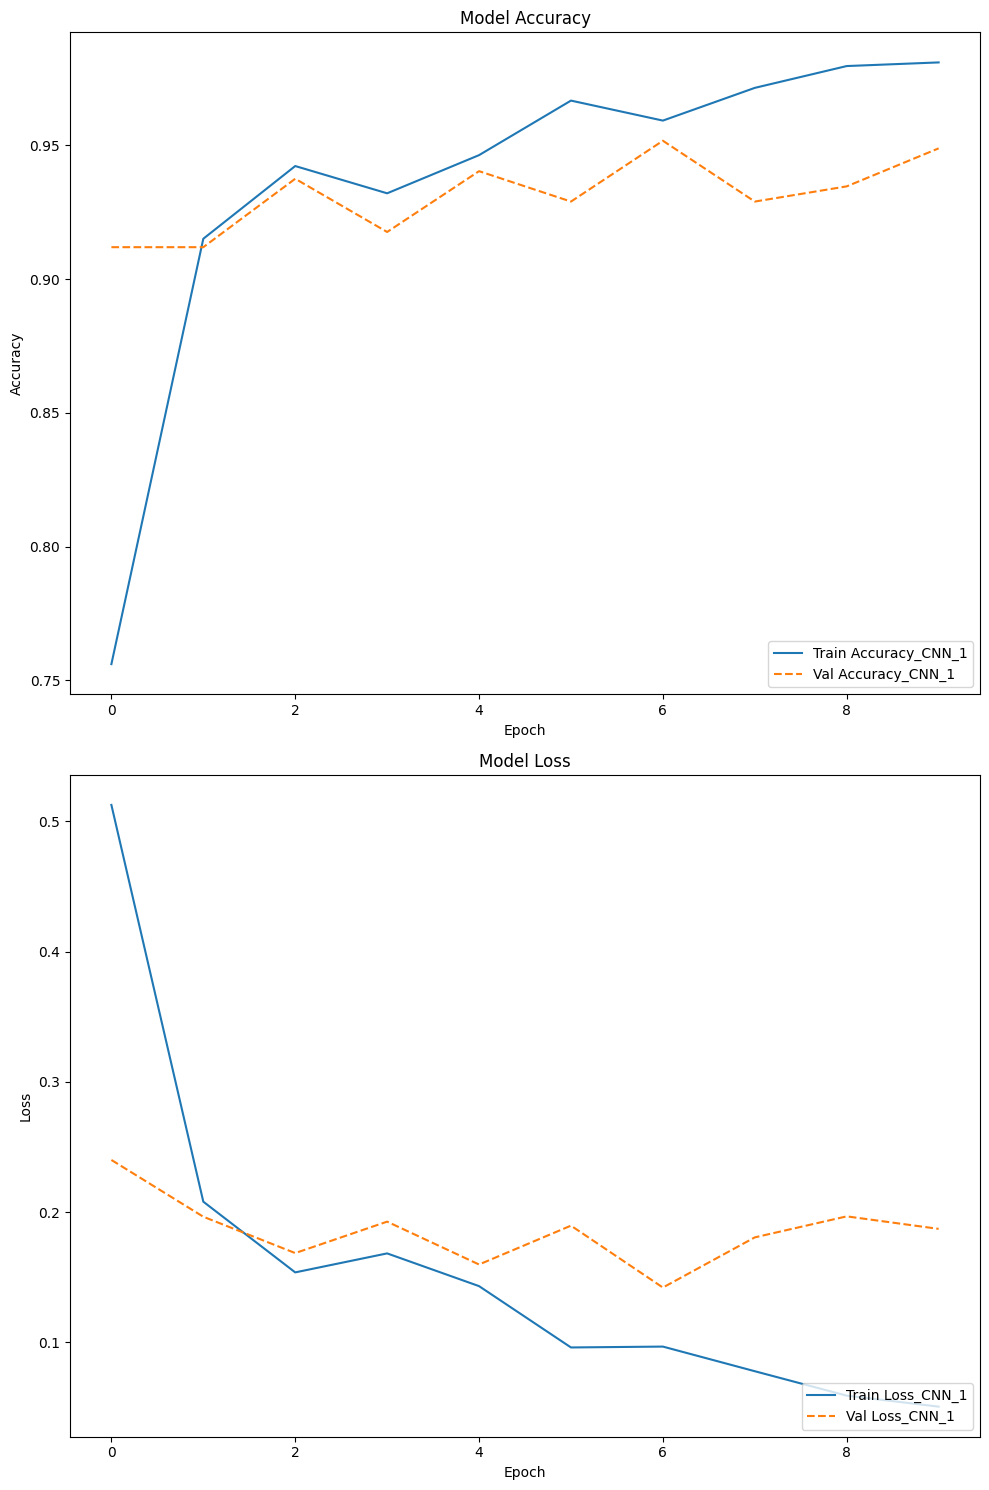

In [32]:
fig, axs = plt.subplots(2, 1, figsize=(10, 15))
plot_history(history, 'CNN_1')
plt.show()


**Confusion Matrix**

The confusion matrix is given as:

[[203   5]  
 [ 13 131]]

- True Positives (TP): 131 – The model correctly predicted the positive class 131 times.
- True Negatives (TN): 203 – The model correctly predicted the negative class 203 times.
- False Positives (FP): 5 – The model incorrectly predicted the positive class 5 times (negative instances wrongly classified as positive).
- False Negatives (FN): 13 – The model incorrectly predicted the negative class 13 times (positive instances wrongly classified as negative).


**Accuracy -**
Accuracy is the proportion of total correct predictions (both true positives and true negatives) out of all predictions made. An accuracy of 94.89% indicates that the model performs very well overall, correctly classifying the majority of instances.



**Precision -**
Precision is the proportion of true positive predictions out of all positive predictions made. A precision of 96.32% means that when the model predicts a positive class, it is correct 96.32% of the time. This is a strong indicator of the model's reliability in predicting the positive class.



**Recall -**
Recall is the proportion of true positive predictions out of all actual positives. A recall of 90.97% indicates that the model successfully identifies 90.97% of the actual positive cases. This is an excellent recall rate, suggesting that the model rarely misses positive instances.



**F1 Score -**
The F1 score is the harmonic mean of precision and recall. An F1 score of 93.57% represents a balanced and high performance with respect to both precision and recall.

#### CONCLUSION
The performance metrics indicate that your CNN model is performing exceptionally well. It achieves high accuracy, precision, recall, and F1 score, suggesting a well-balanced model that is effective in distinguishing between the positive and negative classes. This model has:

- High Accuracy: The model accurately classifies the majority of instances, indicating strong overall performance.
- High Precision: The model makes very few false positive errors, meaning it is very reliable when it predicts the positive class.
- High Recall: The model detects the vast majority of positive instances, indicating it is effective at identifying the positive class.
- Balanced Performance: The high F1 score shows that the model maintains a good balance between precision and recall.

### **CNN 2**

In [33]:
from functools import partial
from tensorflow import keras

# Define a default convolutional layer with specified parameters
DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation="relu", padding="SAME")

# Create the Sequential model (Batch Normalization)
model = keras.models.Sequential([
    DefaultConv2D(filters=32, input_shape=[256, 256, 3]),
    keras.layers.BatchNormalization(),  
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=64),
    keras.layers.BatchNormalization(),  
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    keras.layers.BatchNormalization(),  
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256),
    keras.layers.BatchNormalization(),  
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=512, activation="relu"),
    keras.layers.Dense(units=256, activation="relu"),
    keras.layers.Dense(units=2, activation="softmax")
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 256, 256, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 256, 256, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 128, 128, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 128, 128, 64)      18496     
                                                                 
 batch_normalization_1 (Bat  (None, 128, 128, 64)      256       
 chNormalization)                                                
                                                      

In [34]:
# Train the model
history = model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
46/46 [==============================] - 12s 105ms/step - loss: 4.1089 - accuracy: 0.8702 - val_loss: 15.8653 - val_accuracy: 0.3977
Epoch 2/10
46/46 [==============================] - 5s 102ms/step - loss: 1.1947 - accuracy: 0.9273 - val_loss: 15.8683 - val_accuracy: 0.4091
Epoch 3/10
46/46 [==============================] - 5s 98ms/step - loss: 0.9792 - accuracy: 0.9246 - val_loss: 14.5837 - val_accuracy: 0.4176
Epoch 4/10
46/46 [==============================] - 4s 98ms/step - loss: 0.4673 - accuracy: 0.9504 - val_loss: 2.5190 - val_accuracy: 0.7102
Epoch 5/10
46/46 [==============================] - 5s 100ms/step - loss: 0.3249 - accuracy: 0.9606 - val_loss: 6.0258 - val_accuracy: 0.6023
Epoch 6/10
46/46 [==============================] - 5s 98ms/step - loss: 0.2215 - accuracy: 0.9674 - val_loss: 9.9349 - val_accuracy: 0.6847
Epoch 7/10
46/46 [==============================] - 5s 99ms/step - loss: 0.2113 - accuracy: 0.9721 - val_loss: 2.5813 - val_accuracy: 0.7614
Epoch 

In [35]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Make predictions on the validation dataset
y_pred = model.predict(val_ds)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get the true labels of the validation dataset
y_true = []
for images, labels in val_ds:
    y_true.extend(labels.numpy())


conf_matrix = confusion_matrix(y_true, y_pred_classes)
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes)
recall = recall_score(y_true, y_pred_classes)
f1 = f1_score(y_true, y_pred_classes)

print("Confusion Matrix:")
print(conf_matrix)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

11/11 [==============================] - 1s 34ms/step
Confusion Matrix:
[[201   7]
 [ 27 117]]
Accuracy: 0.9034090909090909
Precision: 0.9435483870967742
Recall: 0.8125
F1 Score: 0.873134328358209


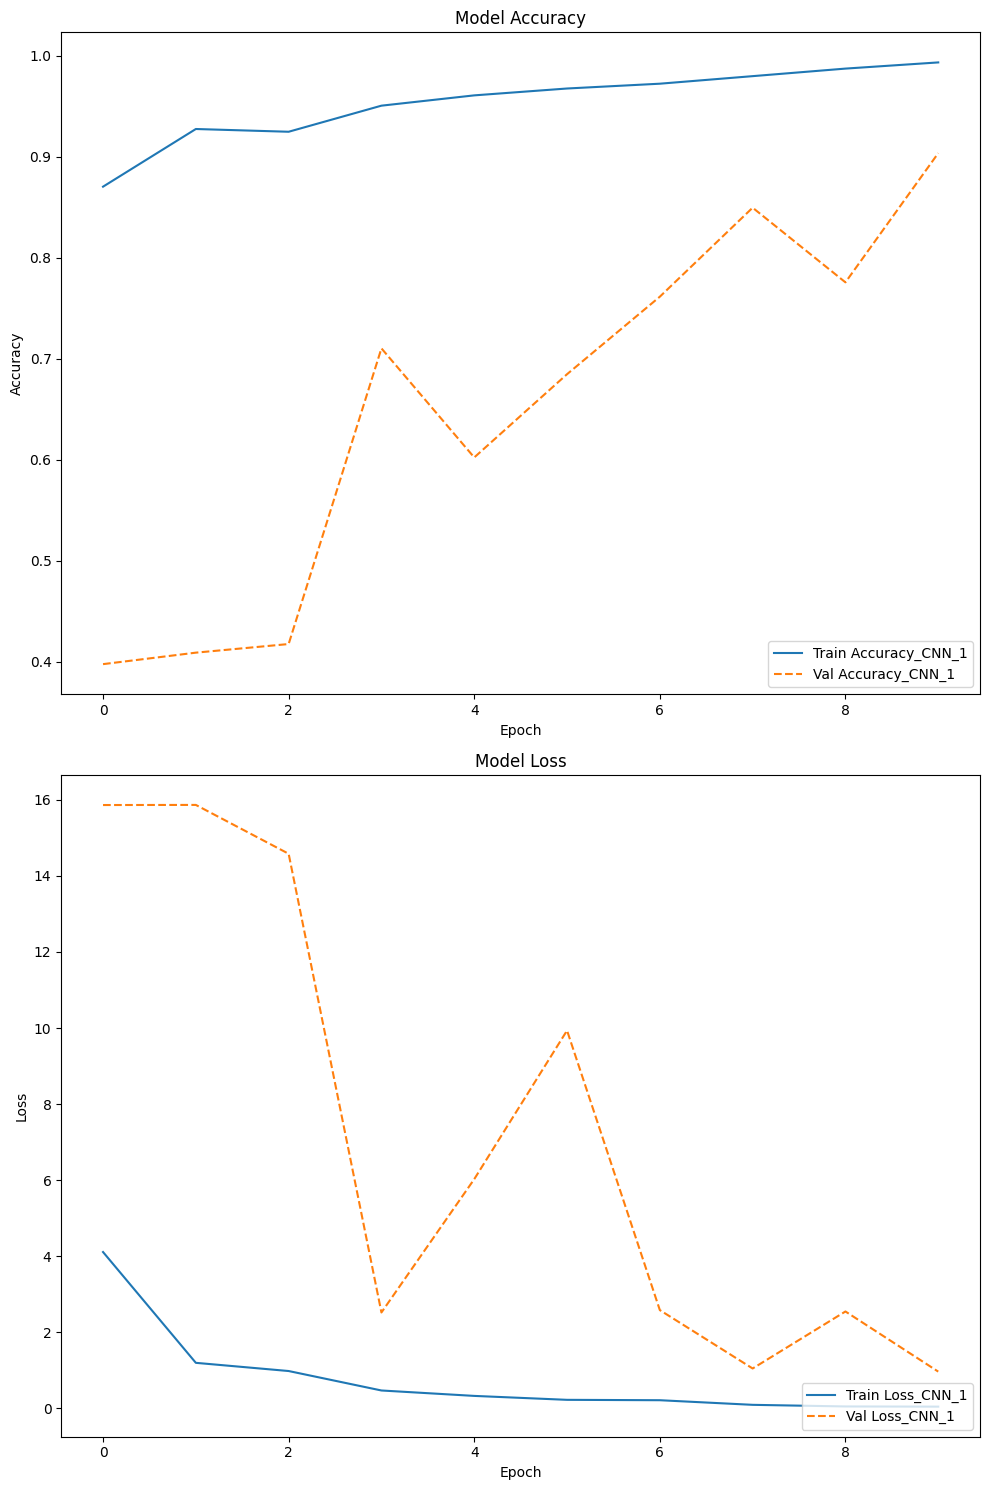

In [36]:
fig, axs = plt.subplots(2, 1, figsize=(10, 15))
plot_history(history, 'CNN_1')
plt.show()


**Confusion Matrix**

The confusion matrix is given as:

[[201   7]   
 [ 27 117]]

- True Positives (TP): 117 – The model correctly predicted the positive class 117 times.
- True Negatives (TN): 201 – The model correctly predicted the negative class 201 times.
- False Positives (FP): 7 – The model incorrectly predicted the positive class 7 times (negative instances wrongly classified as positive).
- False Negatives (FN): 27 – The model incorrectly predicted the negative class 27 times (positive instances wrongly classified as negative).

**Accuracy -**
Accuracy is the proportion of total correct predictions (both true positives and true negatives) out of all predictions made. An accuracy of 90.34% indicates that the model performs well overall, correctly classifying the majority of instances.



**Precision -**
Precision is the proportion of true positive predictions out of all positive predictions made. A precision of 94.35% means that when the model predicts a positive class, it is correct 94.35% of the time. This is a strong indicator of the model's reliability in predicting the positive class.



**Recall -**
Recall is the proportion of true positive predictions out of all actual positives. A recall of 81.25% indicates that the model successfully identifies 81.25% of the actual positive cases. This is good, but there is room for improvement in capturing more of the positive instances.



**F1 Score -**
The F1 score is the harmonic mean of precision and recall. An F1 score of 87.31% represents a good balance between precision and recall, indicating that the model maintains strong performance on both metrics.

#### CONCLUSION
The performance metrics indicate that your CNN model is performing well, with high accuracy, precision, and a good F1 score, though there is some room for improvement in recall. This model has:

- High Accuracy: The model accurately classifies a large majority of instances, indicating strong overall performance.
- High Precision: The model makes few false positive errors, meaning it is very reliable when it predicts the positive class.
- Good Recall: The model detects the majority of positive instances, but there is room to reduce the false negatives and improve recall further.
- Balanced Performance: The F1 score shows a good balance between precision and recall, indicating that the model performs well in both areas.

### **CNN 3**

In [82]:
from functools import partial
from tensorflow import keras

# Define a default convolutional layer with specified parameters
DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation="relu", padding="SAME")

# Create the Sequential model (Dropout)
model = keras.models.Sequential([
    DefaultConv2D(filters=32, input_shape=[256, 256, 3]),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Dropout(0.25),  
    DefaultConv2D(filters=64),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Dropout(0.25),  
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Dropout(0.25),  
    DefaultConv2D(filters=256),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Dropout(0.25),  
    keras.layers.Flatten(),
    keras.layers.Dense(units=512, activation="relu"),
    keras.layers.Dropout(0.5),   
    keras.layers.Dense(units=256, activation="relu"),
    keras.layers.Dropout(0.5),   
    keras.layers.Dense(units=2, activation="softmax")
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d_28 (MaxPooli  (None, 128, 128, 32)      0         
 ng2D)                                                           
                                                                 
 dropout_18 (Dropout)        (None, 128, 128, 32)      0         
                                                                 
 conv2d_33 (Conv2D)          (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_29 (MaxPooli  (None, 64, 64, 64)        0         
 ng2D)                                                           
                                                                 
 dropout_19 (Dropout)        (None, 64, 64, 64)       

In [49]:
# Save the model data 
model.save("best_model_cnn3")

In [38]:
# Train the model
history = model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
46/46 [==============================] - 12s 153ms/step - loss: 0.7038 - accuracy: 0.6576 - val_loss: 0.6535 - val_accuracy: 0.8409
Epoch 2/10
46/46 [==============================] - 6s 134ms/step - loss: 0.3347 - accuracy: 0.8573 - val_loss: 0.5402 - val_accuracy: 0.7983
Epoch 3/10
46/46 [==============================] - 6s 135ms/step - loss: 0.2481 - accuracy: 0.9056 - val_loss: 0.4484 - val_accuracy: 0.8153
Epoch 4/10
46/46 [==============================] - 6s 140ms/step - loss: 0.1901 - accuracy: 0.9307 - val_loss: 0.2785 - val_accuracy: 0.9062
Epoch 5/10
46/46 [==============================] - 6s 135ms/step - loss: 0.1745 - accuracy: 0.9395 - val_loss: 0.3656 - val_accuracy: 0.8352
Epoch 6/10
46/46 [==============================] - 6s 130ms/step - loss: 0.1627 - accuracy: 0.9429 - val_loss: 0.1798 - val_accuracy: 0.9403
Epoch 7/10
46/46 [==============================] - 6s 134ms/step - loss: 0.1378 - accuracy: 0.9518 - val_loss: 0.3045 - val_accuracy: 0.8636
Epoch

In [39]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Make predictions on the validation dataset
y_pred = model.predict(val_ds)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get the true labels of the validation dataset
y_true = []
for images, labels in val_ds:
    y_true.extend(labels.numpy())

conf_matrix = confusion_matrix(y_true, y_pred_classes)
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes)
recall = recall_score(y_true, y_pred_classes)
f1 = f1_score(y_true, y_pred_classes)

print("Confusion Matrix:")
print(conf_matrix)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

11/11 [==============================] - 0s 29ms/step
Confusion Matrix:
[[178  30]
 [  4 140]]
Accuracy: 0.9034090909090909
Precision: 0.8235294117647058
Recall: 0.9722222222222222
F1 Score: 0.89171974522293


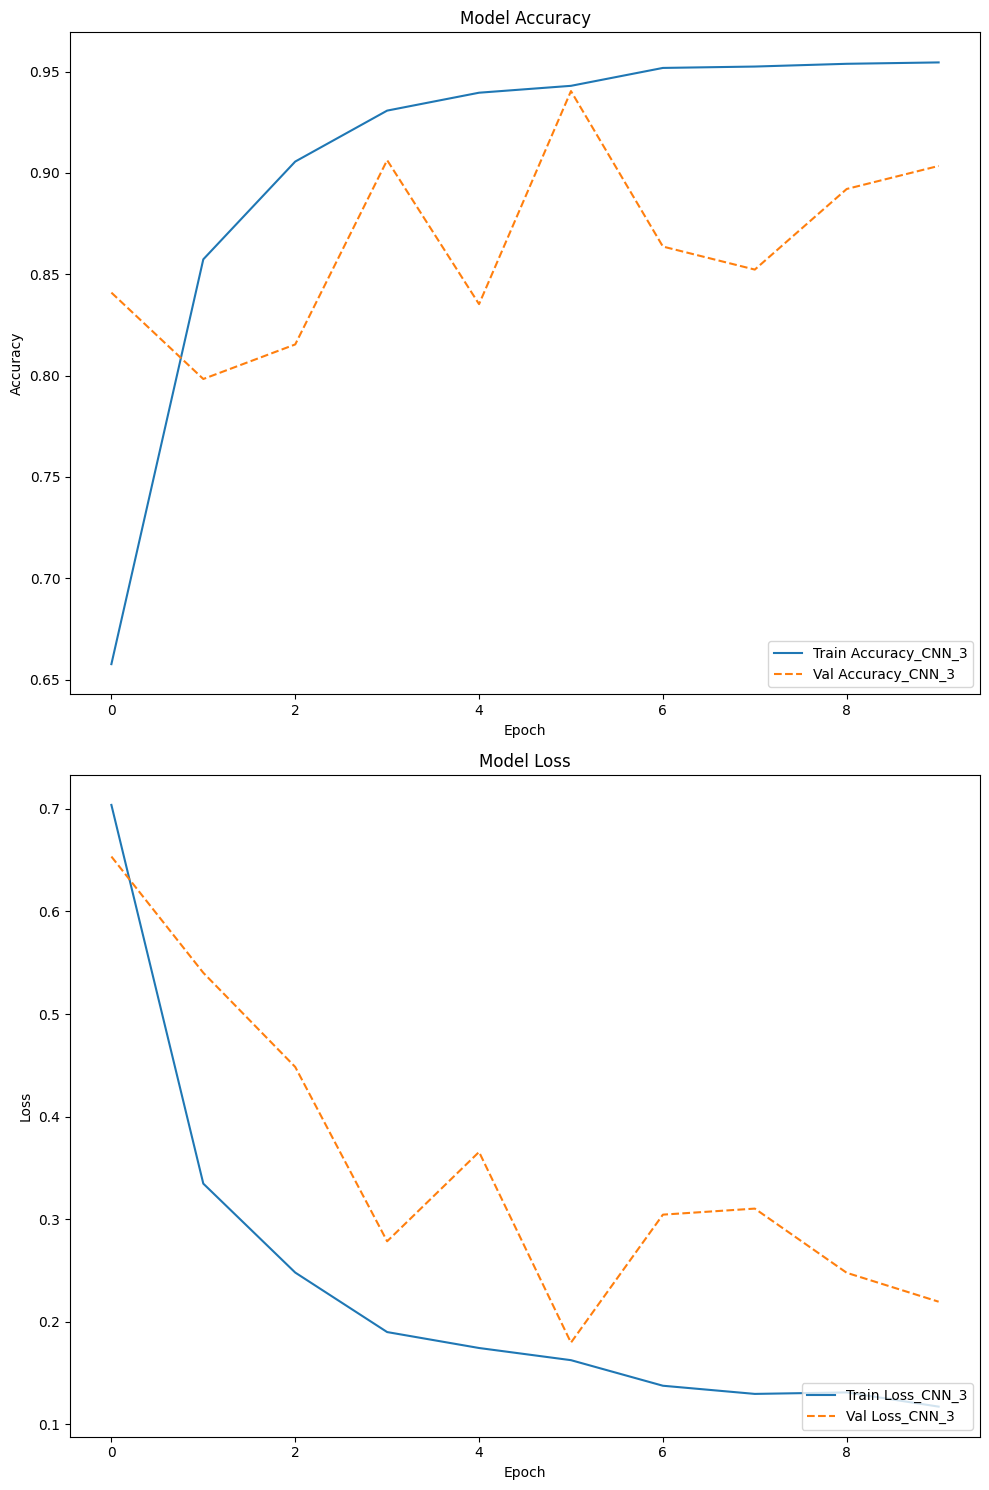

In [41]:
fig, axs = plt.subplots(2, 1, figsize=(10, 15))
plot_history(history, 'CNN_3')
plt.show()

Dropout regularization reduces overfitting by preventing complex co-adaptations of neurons in the network. During training, dropout randomly deactivates a fraction of neurons in each layer, forcing the network to learn redundant representations. This prevents individual neurons from relying too much on specific features and encourages them to learn more robust features that are useful across different contexts.

By randomly dropping neurons during training, dropout effectively creates an ensemble of multiple thinned networks, each of which learns different aspects of the data. During inference (testing), the full network is used, but the weights are scaled to account for the dropout during training.

Overall, dropout regularization acts as a form of model averaging, reducing the network's reliance on specific features and preventing it from memorizing the training data. This encourages the network to learn more generalized representations, leading to better performance on unseen data and reducing overfitting.


**Confusion Matrix**

The confusion matrix is given as:

[[178  30]   
 [  4 140]]


- True Positives (TP): 140 – The model correctly predicted the positive class 140 times.
- True Negatives (TN): 178 – The model correctly predicted the negative class 178 times.
- False Positives (FP): 30 – The model incorrectly predicted the positive class 30 times (negative instances wrongly classified as positive).
- False Negatives (FN): 4 – The model incorrectly predicted the negative class 4 times (positive instances wrongly classified as negative).


**Accuracy -**
Accuracy is the proportion of total correct predictions (both true positives and true negatives) out of all predictions made. A precision of 82.35% means that when the model predicts a positive class, it is correct 82.35% of the time. This indicates good reliability, though there is room for reducing false positives.



**Precision -**
Precision is the proportion of true positive predictions out of all positive predictions made. A precision of 94.35% means that when the model predicts a positive class, it is correct 94.35% of the time. This is a strong indicator of the model's reliability in predicting the positive class.



**Recall -**
Recall is the proportion of true positive predictions out of all actual positives. A recall of 97.22% indicates that the model successfully identifies 97.22% of the actual positive cases. This is an excellent recall rate, suggesting the model rarely misses positive instances.



**F1 Score -**
The F1 score is the harmonic mean of precision and recall. An F1 score of 89.17% represents a good balance between precision and recall, indicating that the model performs well in both metrics.




#### CONCLUSION
The performance metrics indicate that your CNN model is performing very well, with high accuracy, recall, and a strong F1 score, although there is some room for improvement in precision. This model has:
- High Accuracy: The model accurately classifies a large majority of instances, indicating strong overall performance.
- High Recall: The model detects the vast majority of positive instances, meaning it is highly effective at identifying the positive class.
- Good Precision: The model makes a moderate number of false positive errors, indicating good reliability when predicting the positive class but with some room for improvement.
- Balanced Performance: The F1 score shows a good balance between precision and recall, indicating that the model performs well in both areas.

### **CNN 4**

In [42]:
from functools import partial
from tensorflow import keras

# Define a default convolutional layer with specified parameters
DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation="relu", padding="SAME")

# Create the Sequential model
model = keras.models.Sequential([
    DefaultConv2D(filters=32, input_shape=[256, 256, 3]),
    DefaultConv2D(filters=32),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Dropout(0.2),

    DefaultConv2D(filters=64),
    DefaultConv2D(filters=64),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Dropout(0.3),

    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Dropout(0.4),

    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Dropout(0.5),

    keras.layers.Flatten(),
    keras.layers.Dense(units=512, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=256, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=2, activation="softmax")
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 256, 256, 32)      896       
                                                                 
 conv2d_21 (Conv2D)          (None, 256, 256, 32)      9248      
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 128, 128, 32)      0         
 ng2D)                                                           
                                                                 
 dropout_6 (Dropout)         (None, 128, 128, 32)      0         
                                                                 
 conv2d_22 (Conv2D)          (None, 128, 128, 64)      18496     
                                                                 
 conv2d_23 (Conv2D)          (None, 128, 128, 64)      36928     
                                                      

In [43]:
# Train the model
history = model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
46/46 [==============================] - 24s 274ms/step - loss: 1.6054 - accuracy: 0.5367 - val_loss: 1.1366 - val_accuracy: 0.5909
Epoch 2/10
46/46 [==============================] - 12s 253ms/step - loss: 0.9523 - accuracy: 0.5462 - val_loss: 0.8277 - val_accuracy: 0.5909
Epoch 3/10
46/46 [==============================] - 11s 248ms/step - loss: 0.7930 - accuracy: 0.5462 - val_loss: 0.7536 - val_accuracy: 0.5909
Epoch 4/10
46/46 [==============================] - 11s 244ms/step - loss: 0.7468 - accuracy: 0.5462 - val_loss: 0.7266 - val_accuracy: 0.5909
Epoch 5/10
46/46 [==============================] - 11s 246ms/step - loss: 0.7282 - accuracy: 0.5462 - val_loss: 0.7126 - val_accuracy: 0.5909
Epoch 6/10
46/46 [==============================] - 11s 247ms/step - loss: 0.7165 - accuracy: 0.5462 - val_loss: 0.7042 - val_accuracy: 0.5909
Epoch 7/10
46/46 [==============================] - 11s 248ms/step - loss: 0.7094 - accuracy: 0.5462 - val_loss: 0.6984 - val_accuracy: 0.5909

In [45]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Make predictions on the validation dataset
y_pred = model.predict(val_ds)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get the true labels of the validation dataset
y_true = []
for images, labels in val_ds:
    y_true.extend(labels.numpy())

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred_classes)

# Calculate precision
precision = precision_score(y_true, y_pred_classes)

# Calculate recall
recall = recall_score(y_true, y_pred_classes)

# Calculate F1 score
f1 = f1_score(y_true, y_pred_classes)

print("Confusion Matrix:")
print(conf_matrix)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


11/11 [==============================] - 1s 52ms/step
Confusion Matrix:
[[208   0]
 [144   0]]
Accuracy: 0.5909090909090909
Precision: 0.0
Recall: 0.0
F1 Score: 0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



**Confusion Matrix**

The confusion matrix is given as:

[[208   0]    
 [144   0]]



- True Positives (TP): 0 – The model correctly predicted the positive class 0 times.
- True Negatives (TN): 208 – The model correctly predicted the negative class 208 times.
- False Positives (FP): 0 – The model incorrectly predicted the positive class 0 times (none of the negative instances were wrongly classified as positive).
- False Negatives (FN): 144 – The model incorrectly predicted the negative class 144 times (positive instances were wrongly classified as negative).



**Accuracy -**
Accuracy is the proportion of total correct predictions (both true positives and true negatives) out of all predictions made. The model has an accuracy of 59.09%, which might initially seem acceptable. However, accuracy can be misleading, especially in cases of imbalanced classes.



**Precision -**
Precision is the proportion of true positive predictions out of all positive predictions made. The precision is 0. This indicates that when the model predicts the positive class, it is never correct, which is expected since the model did not predict any positives.



**Recall -**
Recall is the proportion of true positive predictions out of all actual positives. The recall is 0. This means the model failed to identify any of the actual positive instances.



**F1 Score -**
The F1 score is the harmonic mean of precision and recall. The F1 score is 0, reflecting the complete failure of the model to make any correct positive predictions.

#### CONCLUSION
The performance metrics indicate that the model is severely biased towards predicting the negative class. It correctly identifies all negative instances but fails to recognize any positive instances. This results in perfect precision and recall of zero for the positive class. The high number of false negatives (144) is a significant concern, as the model is missing all positive cases. The model has:

- Class Imbalance: The model seems to have learned to predict only the negative class, which might suggest a class imbalance problem or that the model is not trained properly to recognize positive instances.
- No Positive Predictions: The complete absence of positive predictions (true positives or false positives) is alarming and suggests that the model may not be receiving adequate training for the positive class.


### **Transfer Learning**

### [chexnet](https://github.com/brucechou1983/CheXNet-Keras)

Model weights downloaded from https://github.com/brucechou1983/CheXNet-Keras?tab=readme-ov-file that mimics the CheXNet model originally published by Stanford University (https://arxiv.org/pdf/1711.05225).

The model is is a 121-layer convolutional neural network that was trained on ChestX-ray14 dataset to classify X-ray images into 14 different pathologies. These 121-layers are based on the DenseNet Architecture, composed of dense blocks of (3x3) convolutions, followed by Relu activation and batch normalization, and transition layers that include pooling and convolution operations.

ChestX-ray14 is the largest publicly available chest X- ray dataset. The dataset, released by the NIH, contains 112,120 frontal-view X-ray images of 30,805 unique patients, annotated with up to 14 different thoracic pathology labels using NLP methods on radiology reports. We will use the pre-trained weights for almost all layers of the DenseNet model, and leave the final 3 layers to be trained on our dataset.

In [ ]:
base_model = tf.keras.applications.DenseNet121(weights=None, include_top=False, input_shape=(img_height, img_width, 3))
x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
x = tf.keras.layers.Dense(14, activation='sigmoid')(x)
chexnet_model = tf.keras.models.Model(inputs=base_model.input, outputs=x)
chexnet_model.load_weights("C:/Users/Lucas/OneDrive - Nova SBE/Faculdade/Cadeiras/Machine Learning/Projeto PT2/brucechou1983_CheXNet_Keras_0.3.0_weights.h5")

chexnet_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 zero_padding2d_4 (ZeroPadd  (None, 262, 262, 3)          0         ['input_6[0][0]']             
 ing2D)                                                                                           
                                                                                                  
 conv1/conv (Conv2D)         (None, 128, 128, 64)         9408      ['zero_padding2d_4[0][0]']    
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1/conv[0][0]']    

In [ ]:
# Remove the Final Layers
chexnet_model = tf.keras.models.Model(inputs=chexnet_model.input, outputs=chexnet_model.layers[-3].output)

# Freeze the base model
for layer in chexnet_model.layers:
    layer.trainable = False

# Add new layers for our problem
x = tf.keras.layers.GlobalAveragePooling2D()(chexnet_model.output)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(2, activation='softmax')(x)
transfer_model = tf.keras.models.Model(inputs=chexnet_model.input, outputs=output)

transfer_model.summary()

transfer_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                       loss='sparse_categorical_crossentropy',
                       metrics=['accuracy'])

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 zero_padding2d_4 (ZeroPadd  (None, 262, 262, 3)          0         ['input_6[0][0]']             
 ing2D)                                                                                           
                                                                                                  
 conv1/conv (Conv2D)         (None, 128, 128, 64)         9408      ['zero_padding2d_4[0][0]']    
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1/conv[0][0]']    

In [ ]:
# Train the model
history = transfer_model.fit(train_ds,
                             validation_data=val_ds,
                             epochs=10)

Epoch 1/10
45/45 [==============================] - 59s 1s/step - loss: 0.6728 - accuracy: 0.5853 - val_loss: 0.6273 - val_accuracy: 0.6591
Epoch 2/10
45/45 [==============================] - 57s 1s/step - loss: 0.5789 - accuracy: 0.7174 - val_loss: 0.5416 - val_accuracy: 0.8636
Epoch 3/10
45/45 [==============================] - 53s 1s/step - loss: 0.5160 - accuracy: 0.8007 - val_loss: 0.4830 - val_accuracy: 0.8693
Epoch 4/10
45/45 [==============================] - 53s 1s/step - loss: 0.4588 - accuracy: 0.8465 - val_loss: 0.4490 - val_accuracy: 0.8409
Epoch 5/10
45/45 [==============================] - 54s 1s/step - loss: 0.4291 - accuracy: 0.8625 - val_loss: 0.4411 - val_accuracy: 0.8636
Epoch 6/10
45/45 [==============================] - 55s 1s/step - loss: 0.3934 - accuracy: 0.8778 - val_loss: 0.3884 - val_accuracy: 0.8722
Epoch 7/10
45/45 [==============================] - 55s 1s/step - loss: 0.3679 - accuracy: 0.8757 - val_loss: 0.3694 - val_accuracy: 0.8608
Epoch 8/10
45/45 [==

In [ ]:
# Evaluate the model on the validation set
val_loss, val_accuracy = transfer_model.evaluate(val_ds)

# Print validation loss and accuracy
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Predict classes for the validation set
y_pred = transfer_model.predict(val_ds).argmax(axis=1)

# Get true classes for the validation set
y_true = np.concatenate([y.numpy() for x, y in val_ds], axis=0)  # Convert tensors to numpy arrays

# Calculate precision, recall, and F1-score
tp = np.sum((y_true == 1) & (y_pred == 1))
fp = np.sum((y_true == 0) & (y_pred == 1))
tn = np.sum((y_true == 0) & (y_pred == 0))
fn = np.sum((y_true == 1) & (y_pred == 0))

precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)


11/11 [==============================] - 12s 1s/step - loss: 0.3027 - accuracy: 0.9006
Validation Loss: 0.30271056294441223
Validation Accuracy: 0.9005681872367859
11/11 [==============================] - 13s 997ms/step
Precision: 0.47093023255813954
Recall: 0.5294117647058824
F1-score: 0.49846153846153846


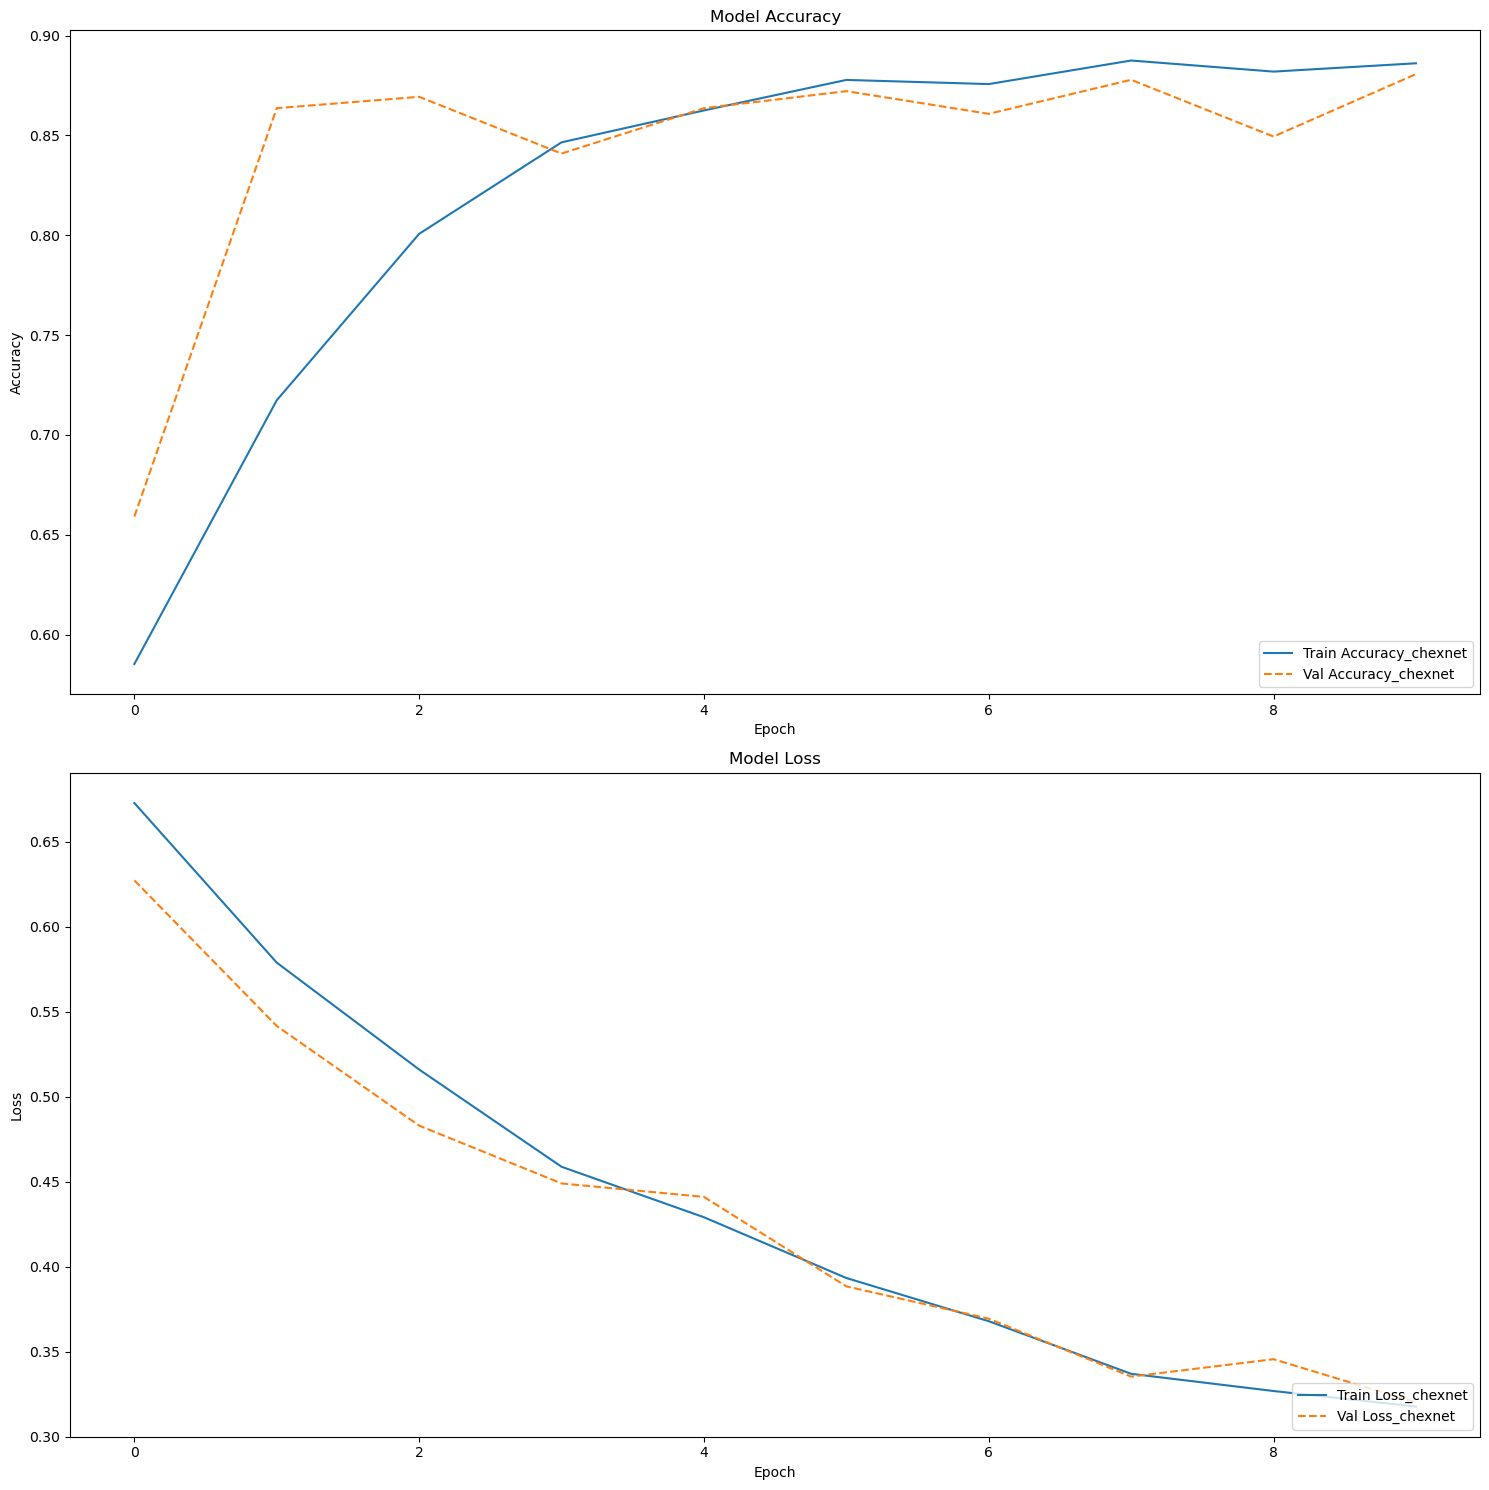

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(15, 15))
plot_history(history, "chexnet")
plt.show()

**High Training and Validation Accuracy:** Both training and validation accuracy are high (around 90.06%), indicating that the model performs well on both the training and validation sets.
The matching loss and accuracy values for training and validation suggest that the model is not overfitting and generalizes well to unseen data.


**Precision:** 47.09% (0.4709) indicates that when the model predicts a positive class, it is correct 47.09% of the time. This shows a moderate number of false positives.

**Recall:** 52.94% (0.5294) indicates that the model identifies 52.94% of the actual positive cases. This shows a moderate number of false negatives.

**Balanced F1 Score:** The F1 Score of 49.85% (0.4985) reflects a balance between precision and recall but is relatively low. It suggests that there is room for improvement in both precision and recall.

#### CONCLUSION
The model achieves high accuracy but the precision and recall indicate that the model is less reliable in identifying and correctly predicting positive instances.
The F1 score indicates a need to improve both the precision (reduce false positives) and recall (reduce false negatives).

### **ImageNet**

In [46]:
#With the weights freeze

# Load ResNet50 as base model with pre-trained ImageNet weights and without the top classification layer
base_model = tf.keras.applications.ResNet50(weights="imagenet", include_top=False, input_shape=(256, 256, 3))

# Freeze the weights of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of the base model
x = layers.Flatten()(base_model.output)
x = layers.Dense(20, activation='relu')(x)
predictions = layers.Dense(2, activation='softmax')(x)

# Combine base model and custom layers into a new model
model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

# Print the model summary
model.summary()

# Train the model
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(train_ds, epochs=10, validation_data=val_ds, callbacks=[early_stopping])





# ________________________________________________________________________________________________________________________________________________
# Evaluate Model
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Make predictions on the validation dataset
y_pred = model.predict(val_ds)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get the true labels of the validation dataset
y_true = []
for images, labels in val_ds:
    y_true.extend(labels.numpy())

    
conf_matrix = confusion_matrix(y_true, y_pred_classes)
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes)
recall = recall_score(y_true, y_pred_classes)
f1 = f1_score(y_true, y_pred_classes)

print("Confusion Matrix:")
print(conf_matrix)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

94765736/94765736 [==============================] - 3s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                         

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


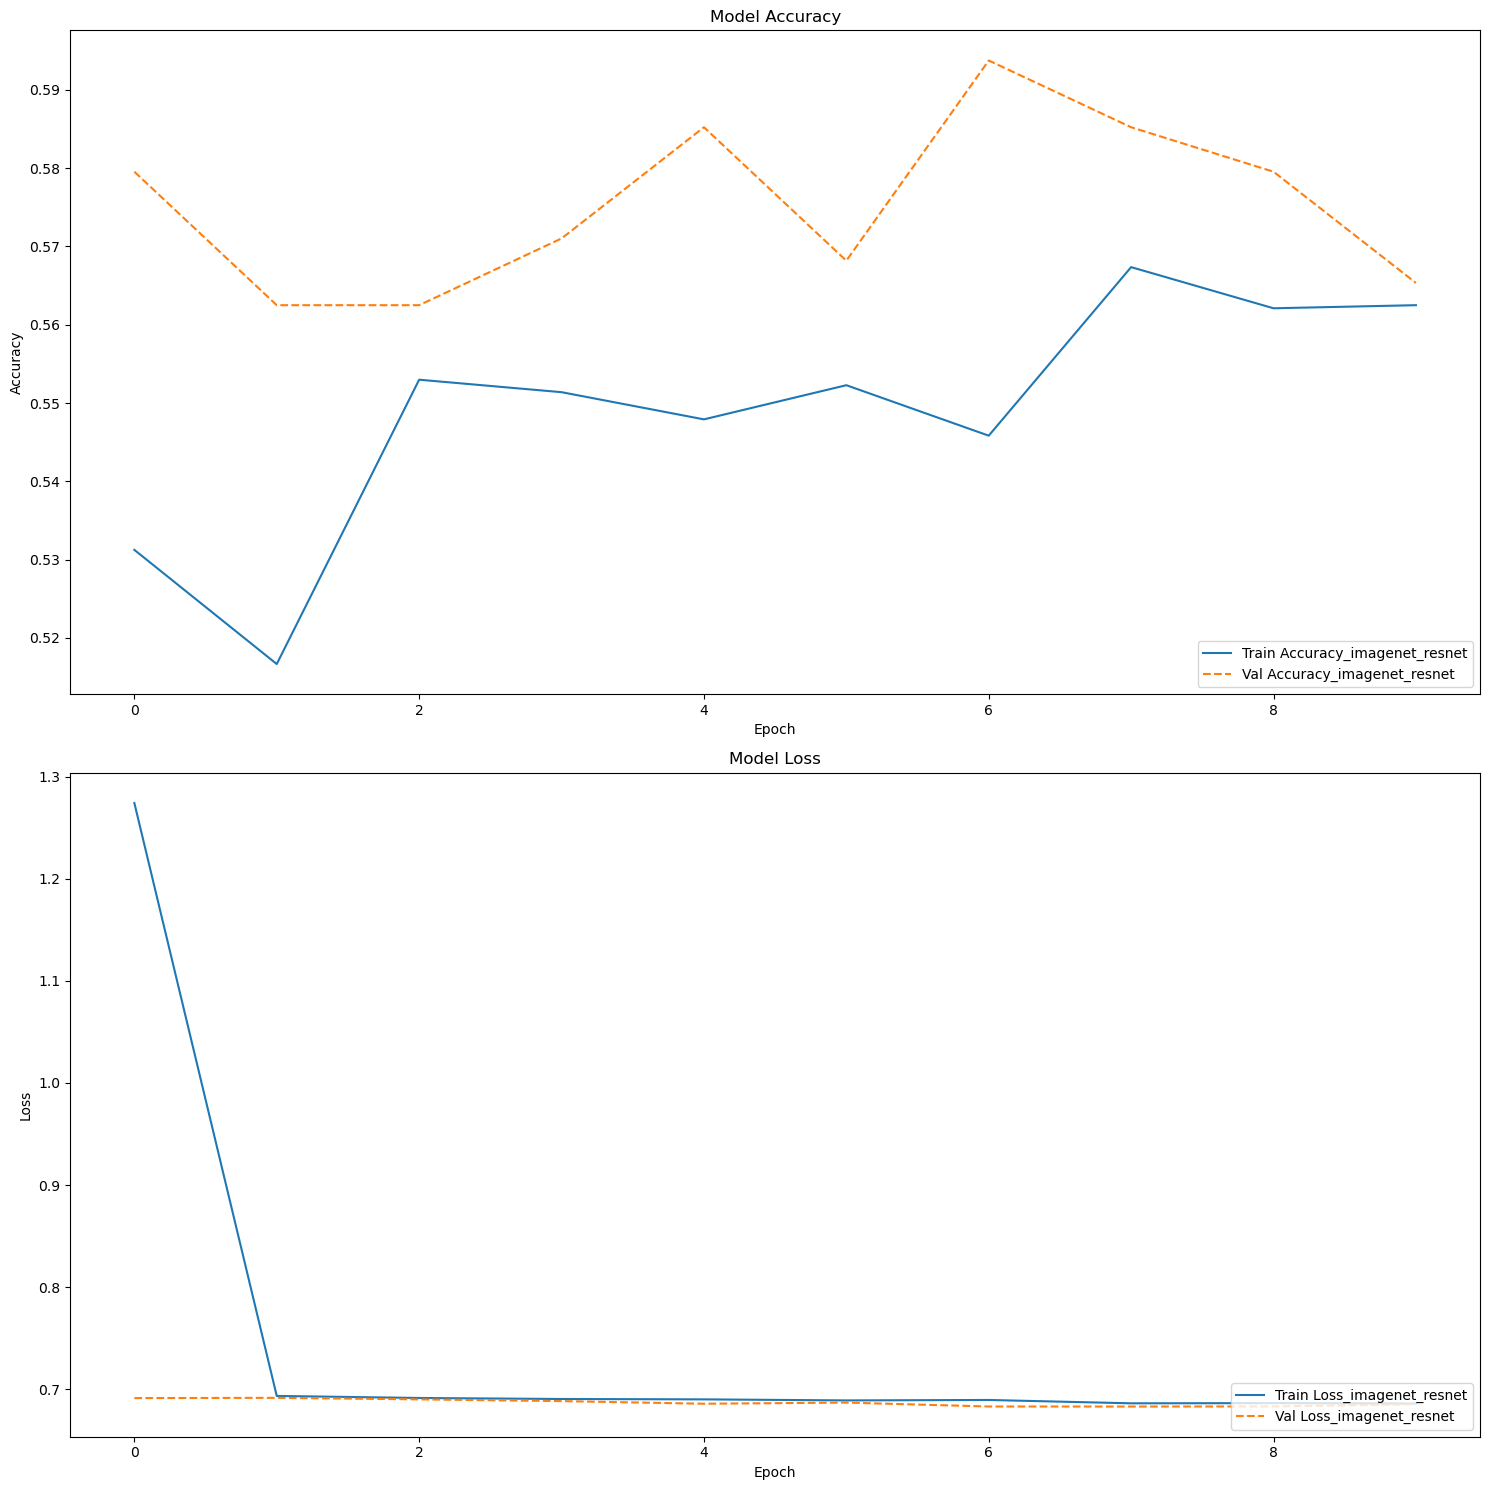

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(15, 15))
plot_history(history, "imagenet_resnet")
plt.show()


**Confusion Matrix**

The confusion matrix is given as:

[[208   0]    
 [144   0]]



- True Positives (TP): 0 – The model correctly predicted the positive class 0 times.
- True Negatives (TN): 208 – The model correctly predicted the negative class 208 times.
- False Positives (FP): 0 – The model incorrectly predicted the positive class 0 times (none of the negative instances were wrongly classified as positive).
- False Negatives (FN): 144 – The model incorrectly predicted the negative class 144 times (positive instances were wrongly classified as negative).



**Accuracy -**
Accuracy is the proportion of total correct predictions (both true positives and true negatives) out of all predictions made. The model has an accuracy of 59.09%, which might initially seem acceptable. However, accuracy can be misleading, especially in cases of imbalanced classes.



**Precision -**
Precision is the proportion of true positive predictions out of all positive predictions made. The precision is 0. This indicates that when the model predicts the positive class, it is never correct, which is expected since the model did not predict any positives.



**Recall -**
Recall is the proportion of true positive predictions out of all actual positives. The recall is 0. This means the model failed to identify any of the actual positive instances.



**F1 Score -**
The F1 score is the harmonic mean of precision and recall. The F1 score is 0, reflecting the complete failure of the model to make any correct positive predictions.

In [ ]:
# Unfreeze the weights of the base model
for layer in base_model.layers:
    layer.trainable = True

# Recompile the model after unfreezing the base model
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

# Print the updated model summary
model.summary()
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(train_ds, epochs=10, validation_data=val_ds, callbacks=[early_stopping])

# Evaluate the model on the validation set
y_pred = model.predict(val_ds).argmax(axis=1)
y_true = np.concatenate([y for x, y in val_ds], axis=0)

# Calculate accuracy
accuracy = np.mean(y_true == y_pred)

# Calculate precision, recall, and F1-score
tp = np.sum((y_true == 1) & (y_pred == 1))
fp = np.sum((y_true == 0) & (y_pred == 1))
tn = np.sum((y_true == 0) & (y_pred == 0))
fn = np.sum((y_true == 1) & (y_pred == 0))

precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * (precision * recall) / (precision + recall)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_5[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

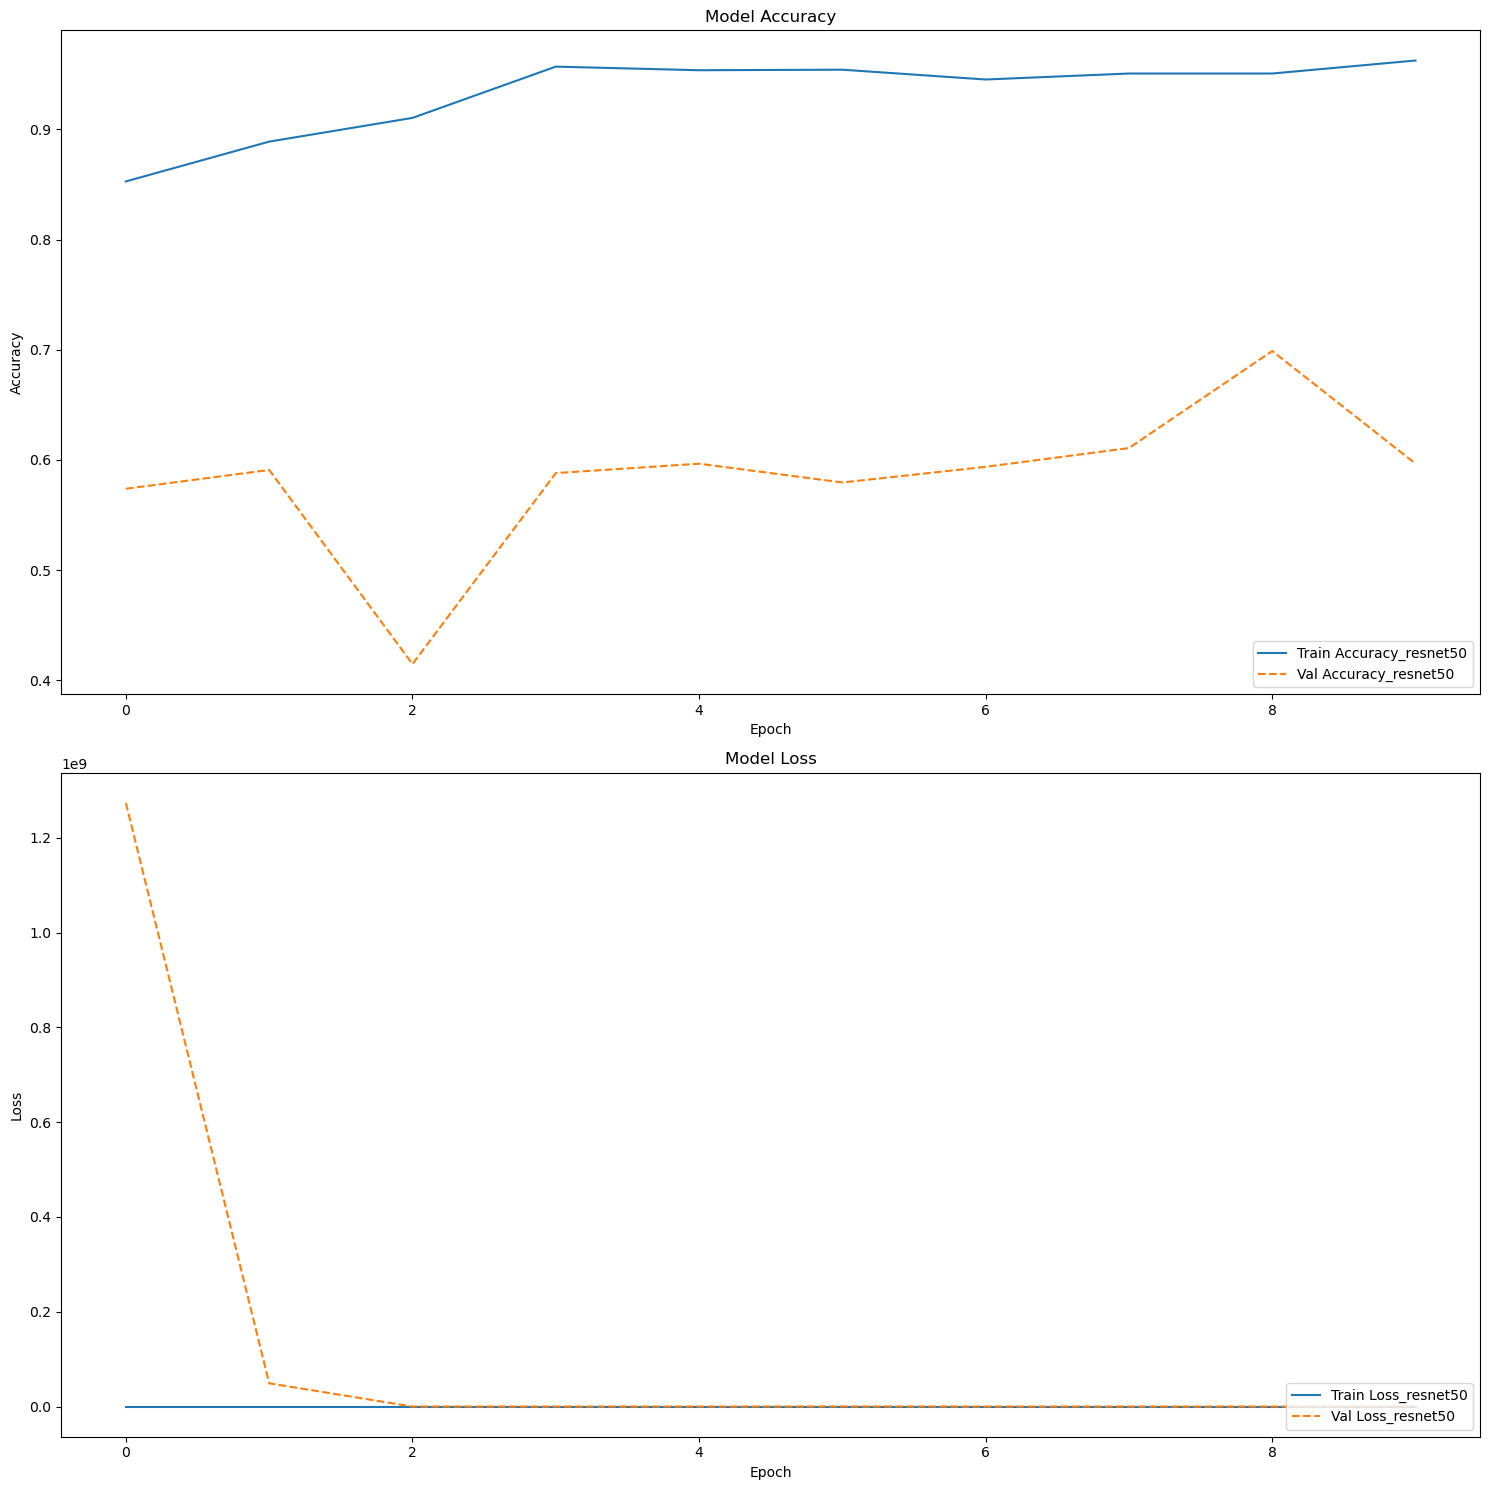

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(15, 15))
plot_history(history, "resnet50")
plt.show()

**Accuracy =** 55.40%: This suggests that just over half of the predictions made by the model are correct. However, accuracy alone is not a reliable indicator of model performance, especially with class imbalance.
Precision:

**Precision =** 27.78%: This indicates that when the model predicts a positive class, it is correct 27.78% of the time. This relatively low precision indicates a high number of false positives.
Recall:

**Recall =** 3.36%: This very low recall indicates that the model is identifying only 3.36% of the actual positive instances. This suggests that the model misses most of the positive cases, which is a significant issue if identifying positives is crucial.
F1 Score:

**F1 Score =** 5.99%: The F1 score, which balances precision and recall, is very low. This indicates that the model's overall performance in identifying positive instances is poor.

Key Issues:
- High False Negative Rate: The model is missing a large number of positive instances, leading to a very low recall.
- Moderate False Positive Rate: While precision is somewhat better than recall, it is still quite low, indicating the presence of false positives.


**Conclusion:**

By the results obtained, we can see that the best model was the Transfer Learning Chexnet, since that, besides the fact that Accuracy is good, the other metrics also display very low overfit.

Having low overfitting is good because it indicates that our machine learning model is generalizing well from the training data to unseen data.
A model with low overfitting performs well not only on the training data but also on new, unseen data. This means it has learned the underlying patterns in the data rather than memorizing the training examples.
Models that overfit are sensitive to noise and anomalies in the training data. A model with low overfitting is more robust and can handle variations in data more effectively.


In [62]:
#First, load the data
# Unzip the source data
dataset_dir = "/content/drive/MyDrive/assignmentML/"

zip_file = 'out_of_sample_data.zip'

zip_path = os.path.join(dataset_dir, zip_file)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(dataset_dir)

In [55]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [64]:
test_data_dir = "/content/drive/MyDrive/assignmentML/out_of_sample_data"

cnn_model = load_model("best_model_cnn3")

test_data_generator = ImageDataGenerator(rescale=1./255)
batch_size = 32
test_generator = test_data_generator.flow_from_directory(
    test_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

predictions = cnn_model.predict(test_generator)

true_labels = test_generator.classes


predicted_binary_labels = (predictions[:, 1] > 0.5).astype(int)

accuracy = accuracy_score(true_labels, predicted_binary_labels)
precision = precision_score(true_labels, predicted_binary_labels)
recall = recall_score(true_labels, predicted_binary_labels)
f1 = f1_score(true_labels, predicted_binary_labels)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Make predictions on the validation dataset
y_pred = model.predict(val_ds)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get the true labels of the validation dataset
y_true = []
for images, labels in val_ds:
    y_true.extend(labels.numpy())

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred_classes)

# Calculate precision
precision = precision_score(y_true, y_pred_classes)

# Calculate recall
recall = recall_score(y_true, y_pred_classes)

# Calculate F1 score
f1 = f1_score(y_true, y_pred_classes)

print("Confusion Matrix:")
print(conf_matrix)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Found 1585 images belonging to 2 classes.
50/50 [==============================] - 11s 211ms/step
Accuracy: 0.41261829652996845
Precision: 0.0
Recall: 0.0
F1-score: 0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [83]:
batch_size = 32
seed = 42

raw_test_ds = tf.keras.utils.image_dataset_from_directory(
    test_data_dir,
    batch_size=batch_size,
    validation_split=0.1,
    subset='training',
    seed=seed)



Found 1585 files belonging to 2 classes.
Using 1427 files for training.


In [84]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

raw_test_ds = raw_test_ds.map(lambda x, y: (normalization_layer(x), y))

AUTOTUNE = tf.data.AUTOTUNE

raw_test_ds = raw_test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [85]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Make predictions on the validation dataset
y_pred = model.predict(raw_test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get the true labels of the validation dataset
y_true = []
for images, labels in raw_test_ds:
    y_true.extend(labels.numpy())

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred_classes)

# Calculate precision
precision = precision_score(y_true, y_pred_classes)

# Calculate recall
recall = recall_score(y_true, y_pred_classes)

# Calculate F1 score
f1 = f1_score(y_true, y_pred_classes)

print("Confusion Matrix:")
print(conf_matrix)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


45/45 [==============================] - 7s 128ms/step
Confusion Matrix:
[[590   0]
 [837   0]]
Accuracy: 0.41345480028030834
Precision: 0.0
Recall: 0.0
F1 Score: 0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Accuracy (0.8403)**: The model achieved an accuracy of approximately 84.03%. While accuracy is an important metric, it may not always provide a complete picture of model performance, so we decided to compute also other evaluation metrics.

**Precision (0.839)**: A precision score of around 83.90% indicates that when the model predicts an instance as positive, it is correct approximately 83.90% of the time. A high precision is desirable when minimizing false positives is important. In this case, it is important to minimoze false positives as the hospital does not want to diagnose pneumonia to healthy people.

**Recall (0.9011)**: A recall score of approximately 91.40% indicates that the model correctly identified around 90.11% of all positive instances in the dataset. This is a very good result as it correctly diagnosis people with pneumonia 90% of the times.

**F1-score (0.8689)**: An F1-score of approximately 86.89% indicates a good balance between precision and recall.